# Final Project
####  Bruno Biadi Corrêa [42963], Catarina Padilha [55465], Gabriella Araújo [57419],  Francisco Carvalho [53876]<br>


## Our goal is to replicate the results in the paper: Quantifying Fiscal Multipliers in New Zealand: the Evidence from SVAR Models, by Anna Hamer-Adams and Martin Wong (2018).<br>

## We quantify fiscal multipliers for New Zealand based on the aggregated model of Hamer-Adams and Wong (2018) using a sample spanning 1990 (Q3) until 2017 (Q4). We aim to understand the dynamic impact of fiscal policy on aggregate demand through the use of SVAR models. Through this, we are able to use an alternative Cholesky specification to calculate impulse response functions and fiscal multipliers. <br>

## The motivation for this project stems from the need for a more flexible software to estimate structural vector autoregressive models. In our Macroeconometrics course, we found the Gretl tool to have some limitations. Thus, our aim is for this project to assist other students in replicating papers on the subject.



### We start by importing the packages and functions that we will need

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pandas_datareader.data import DataReader 
from numpy import linalg as LA
%matplotlib inline

### Now, we import the data. We have the original data used by the authors in an excel file, and we will use pandas to create a dataframe

In [2]:
df = pd.read_excel('Data Project.xlsx', index_col=0, parse_dates=True)

In [3]:
df

,G,NT,Y,DP,I
DATE,,,,,
1990-07-01,0.615082,0.098405,2.075329,0.009991,0.142879
1990-10-01,0.570550,0.103060,2.091817,0.010791,0.138444
1991-01-01,0.584047,0.075223,2.054770,0.006228,0.120922
1991-04-01,0.586651,0.027803,2.042473,0.000884,0.104248
1991-07-01,0.498004,-0.049311,2.049949,0.003534,0.093297
...,...,...,...,...,...
2016-10-01,0.905834,0.963686,2.522910,0.004136,0.020846
2017-01-01,0.896598,0.975417,2.519845,0.009885,0.019930
2017-04-01,0.918058,1.001268,2.530826,0.000000,0.019663


### Let's take a look at the data

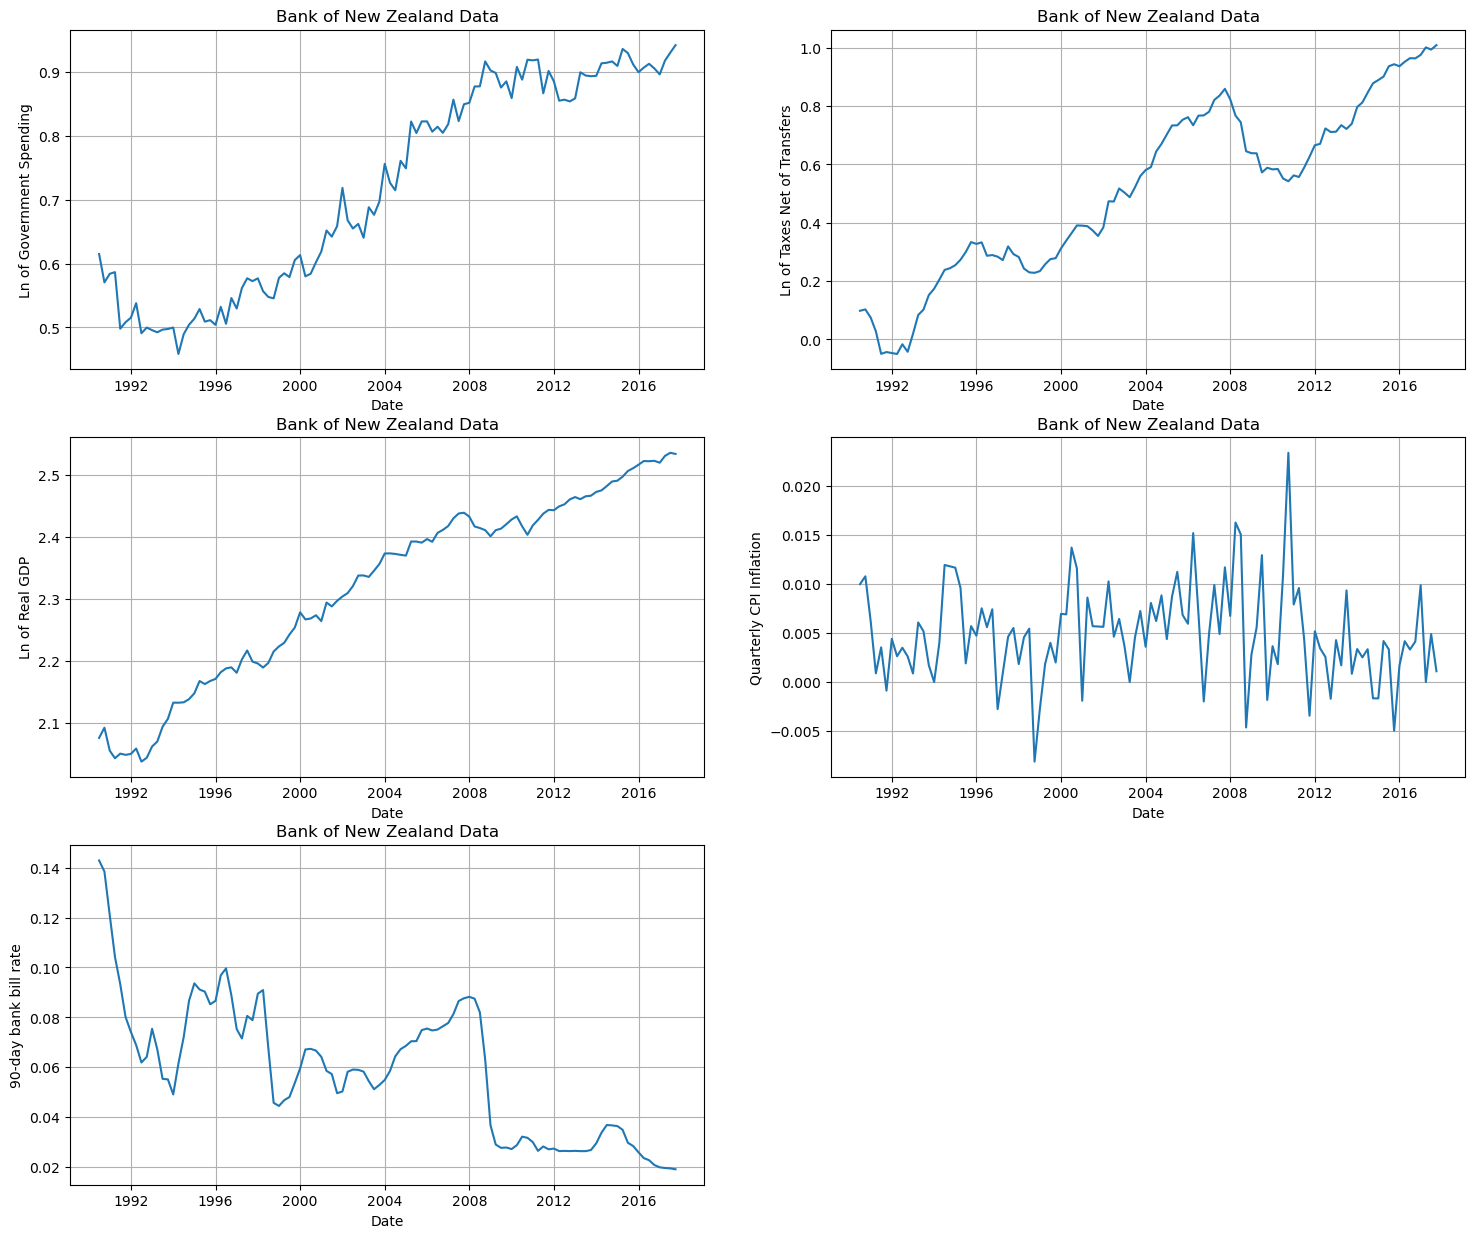

In [4]:
plt.figure(figsize=(18,15))
plt.subplot(321)
plt.plot(df["G"])
plt.xlabel('Date')
plt.ylabel('Ln of Government Spending')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(322)
plt.plot(df["NT"])
plt.xlabel('Date')
plt.ylabel('Ln of Taxes Net of Transfers')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(323)
plt.plot(df["Y"])
plt.xlabel('Date')
plt.ylabel('Ln of Real GDP')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(324)
plt.plot(df["DP"])
plt.xlabel('Date')
plt.ylabel('Quarterly CPI Inflation')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(325)
plt.plot(df["I"])
plt.xlabel('Date')
plt.ylabel('90-day bank bill rate')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.show()

### We have the data, now we need to define a class, so that it can estimate the parameters of the model with our data, identify the structural shocks and create impulse response functions.

In [5]:
class SVAR():
    def __init__(self, X, lags=3, num_impulses = 10):  
        self.X = X
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0]
        self.lags = lags                 # In the paper, they define the model with 3 lags and 10 periods for the impulse response horizons.
        self.num_impulses = num_impulses # So we set these values as default, but create the attributes in case we want to test different specifications
        
    def Xlags(self):  # We need to create a dataframe with lags of our variables to use as dependent variables in the VAR model.
        XLAG = pd.DataFrame()
        for l in range(1,self.lags+1):
            XLAG = pd.concat([XLAG, self.X.shift(l).add_suffix("-"+str(l))], axis=1)
        X_avlb_dta = X.iloc[self.lags:,:]
        XLAG_avlb_dta = XLAG.iloc[self.lags:,:]  # Now we need to exclude from X and XLAG the observations where we have no data available for the lags.
        Xa = np.array(X_avlb_dta)                # And transform them in arrays so later we can perform math/algebra operations with them
        XLAGa = np.array(XLAG_avlb_dta)
        return Xa, XLAGa
    
    def ols_fit(self):   # Here, we use ols to estimate our VAR (reduced form) and recover the coefficients, rediduals and the error variance-covariance matrix
        Xa, XLAGa = self.Xlags()
        Bhat = inv(XLAGa.T@XLAGa)@XLAGa.T@Xa
        U = (Xa-XLAGa@Bhat)
        Ωhat = U.T@U
        return Bhat, U, Ωhat
    
    def identification(self):
        _, U, Ωhat = self.ols_fit()
        C = LA.cholesky(Ωhat)  # Use a cholesky decomposition to obtain a matrix that will be used to identify the structural shocks
        d = np.zeros(C.shape)  # Normalizing the matrix C
        np.fill_diagonal(d, np.diag(C))
        C = np.dot(np.linalg.inv(d), C)
        Ε = U @ inv(C).T   #Multiplying reduced form shocks by inv(C) to obtain the structural shocks Ε.
        return C, Ε
    
    def IRF(self):
        Xa, _ = self.Xlags()
        Bhat, _, _ = self.ols_fit()
        C, _ = self.identification()
        listgy = []
        listnty = []
        for n in range(Xa.shape[0]): # Here we compute the average G/Y and NT/Y throughout our period that we are using to scale the impulse response functions as percentage points of GDP.
            g_over_y = math.exp(Xa[n,0])/math.exp(Xa[n,2])
            listgy.append(g_over_y)
            nt_over_y = math.exp(Xa[n,1])/math.exp(Xa[n,2])
            listnty.append(nt_over_y)
        Avg_gy = sum(listgy)/len(listgy)
        Avg_nty = sum(listnty)/len(listnty)
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars), # Create a canonical form of Bhat to work as this was a VAR(1) (easier to represent as MA)
                                      np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        Temp = np.identity(c_Bhat.shape[0]) # Initialize an array to store the IRF and a temp matrix, that represents the coefficients of the reduced form moving average
        for t in range(self.num_impulses):
            ψ_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = ψ_t @ C # Multiply the coefficients of the reduced form MA by C to obtain the coefficients of the structural form, which gives us our impulse response functions
            Temp = c_Bhat @ Temp # Update Temp to give us this sequence: (I, c_Bhat, (c_Bhat)^2, (c_Bhat)^3,...)
        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(self.num_impulses)}).T #save IRFs into a dataframe, flattening to two dimensions.
        irf.columns = ["Ε_G>G","Ε_NT>G","Ε_Y>G","Ε_CPI>G","Ε_IR>G","Ε_G>NT","Ε_NT>NT","Ε_Y>NT","Ε_CPI>NT","Ε_IR>NT","Ε_G>Y","Ε_NT>Y","Ε_Y>Y","Ε_CPI>Y","Ε_IR>Y","Ε_G>CPI","Ε_NT>CPI","Ε_Y>CPI","Ε_CPI>CPI","Ε_IR>CPI","Ε_G>IR","Ε_NT>IR","Ε_Y>IR","Ε_CPI>IR","Ε_IR>IR"]
        irf[["Ε_G>G","Ε_G>NT","Ε_G>Y","Ε_G>CPI","Ε_G>IR"]] = irf[["Ε_G>G","Ε_G>NT","Ε_G>Y","Ε_G>CPI","Ε_G>IR"]].apply(lambda x: x*(0.01/Avg_gy))
        irf[["Ε_NT>G","Ε_NT>NT","Ε_NT>Y","Ε_NT>CPI","Ε_NT>IR"]] = irf[["Ε_NT>G","Ε_NT>NT","Ε_NT>Y","Ε_NT>CPI","Ε_NT>IR"]].apply(lambda x: x*(-0.01/Avg_nty))  # In these lines we are scaling the IRFs so that the shocks are in ppts of GDP.                                                                                                         
        G_Multiplier1Q = (irf.loc[0, "Ε_G>Y"]/irf.loc[0, "Ε_G>G"])*(1/Avg_gy)
        NT_Multiplier1Q = (irf.loc[0, "Ε_NT>Y"]/abs(irf.loc[0, "Ε_NT>NT"]))*(1/Avg_nty)
        G_Multiplier1Y = (irf.loc[0:3, "Ε_G>Y"].sum()/irf.loc[0:3, "Ε_G>G"].sum())*(1/Avg_gy)
        NT_Multiplier1Y = (irf.loc[0:3, "Ε_NT>Y"].sum()/abs(irf.loc[0:3, "Ε_NT>NT"].sum()))*(1/Avg_nty)
        return c_Bhat, irf, G_Multiplier1Q, NT_Multiplier1Q, G_Multiplier1Y, NT_Multiplier1Y 

### Then, we can use our data to define an instance of the class, call the methods on this instance and check the results

In [18]:
X = df.copy()
Model1 = SVAR(X)
Xa, _ = Model1.Xlags()
Bhat, U, Ωhat = Model1.ols_fit()
C, Ε = Model1.identification()
C

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.07582379,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.2195629 ,  0.30960173,  1.        ,  0.        ,  0.        ],
       [ 0.06084698,  0.00596404, -0.08263682,  1.        ,  0.        ],
       [ 0.0015657 ,  0.21510125, -0.10616454,  0.18353566,  1.        ]])

In [19]:
_, irf, QGM, QNTM, YGM, YNTM = Model1.IRF()
irf

,Ε_G>G,Ε_NT>G,Ε_Y>G,Ε_CPI>G,Ε_IR>G,Ε_G>NT,Ε_NT>NT,Ε_Y>NT,Ε_CPI>NT,Ε_IR>NT,...,Ε_G>CPI,Ε_NT>CPI,Ε_Y>CPI,Ε_CPI>CPI,Ε_IR>CPI,Ε_G>IR,Ε_NT>IR,Ε_Y>IR,Ε_CPI>IR,Ε_IR>IR
0,0.049516,-0.000000e+00,0.000000,0.000000,0.000000,0.003755,-0.060143,0.000000,0.000000,0.000000,...,0.003013,-0.000359,-0.082637,1.000000,0.000000,0.000078,-0.012937,-0.106165,0.183536,1.000000
1,0.024224,1.170636e-02,-0.349046,0.365073,-0.128927,0.006988,-0.069950,0.586970,0.081062,-0.082108,...,0.001488,-0.001925,-0.139887,0.146505,0.357081,0.001695,-0.020594,-0.164472,0.468984,1.447382
2,0.027793,6.286420e-03,-0.086262,0.607690,-0.258616,0.003037,-0.083195,1.012767,-0.492089,-0.124157,...,0.001250,-0.002410,-0.061867,0.062958,0.186407,0.000615,-0.022590,-0.187948,0.444502,1.294187
3,0.025280,4.937318e-03,-0.080935,0.312293,-0.289726,0.003562,-0.075530,1.097489,0.066500,-0.992576,...,-0.000212,-0.000966,-0.001884,0.093727,-0.020229,-0.000128,-0.021370,-0.095732,0.353766,0.960651
4,0.021691,3.471252e-03,-0.013782,0.191180,-0.459820,0.001131,-0.063577,1.134210,-0.078480,-1.665454,...,-0.000094,-0.000584,0.024752,-0.031417,-0.042440,-0.000927,-0.019788,0.007466,0.267396,0.753325
5,0.019669,1.615827e-03,0.104349,0.171135,-0.618165,0.001545,-0.051239,1.238294,-0.194883,-2.218320,...,-0.000167,-0.000237,0.022841,-0.021124,-0.030359,-0.001438,-0.017731,0.045788,0.245314,0.631546
6,0.017763,-4.708843e-07,0.180270,0.072193,-0.706680,0.000576,-0.037702,1.268296,-0.295172,-2.721215,...,-0.000229,-0.000066,0.013084,0.008530,-0.017311,-0.001880,-0.015173,0.044344,0.235472,0.523970
7,0.016043,-9.329778e-04,0.236723,0.029049,-0.812202,0.000180,-0.024100,1.260533,-0.455734,-3.184427,...,-0.000119,0.000040,0.004959,0.003551,-0.010277,-0.002157,-0.012587,0.046208,0.206101,0.417275
8,0.014532,-1.385700e-03,0.291736,-0.002179,-0.924619,0.000069,-0.011462,1.249225,-0.626490,-3.568136,...,-0.000120,0.000155,0.003433,-0.002049,-0.013666,-0.002369,-0.010158,0.054439,0.164234,0.319576
9,0.013275,-1.463940e-03,0.342430,-0.048885,-1.031453,0.000267,-0.000500,1.231189,-0.775354,-3.845996,...,-0.000122,0.000216,0.005539,-0.003990,-0.017414,-0.002537,-0.007907,0.059881,0.123637,0.236445


### Now that we have our impulse response functions, we can plot them

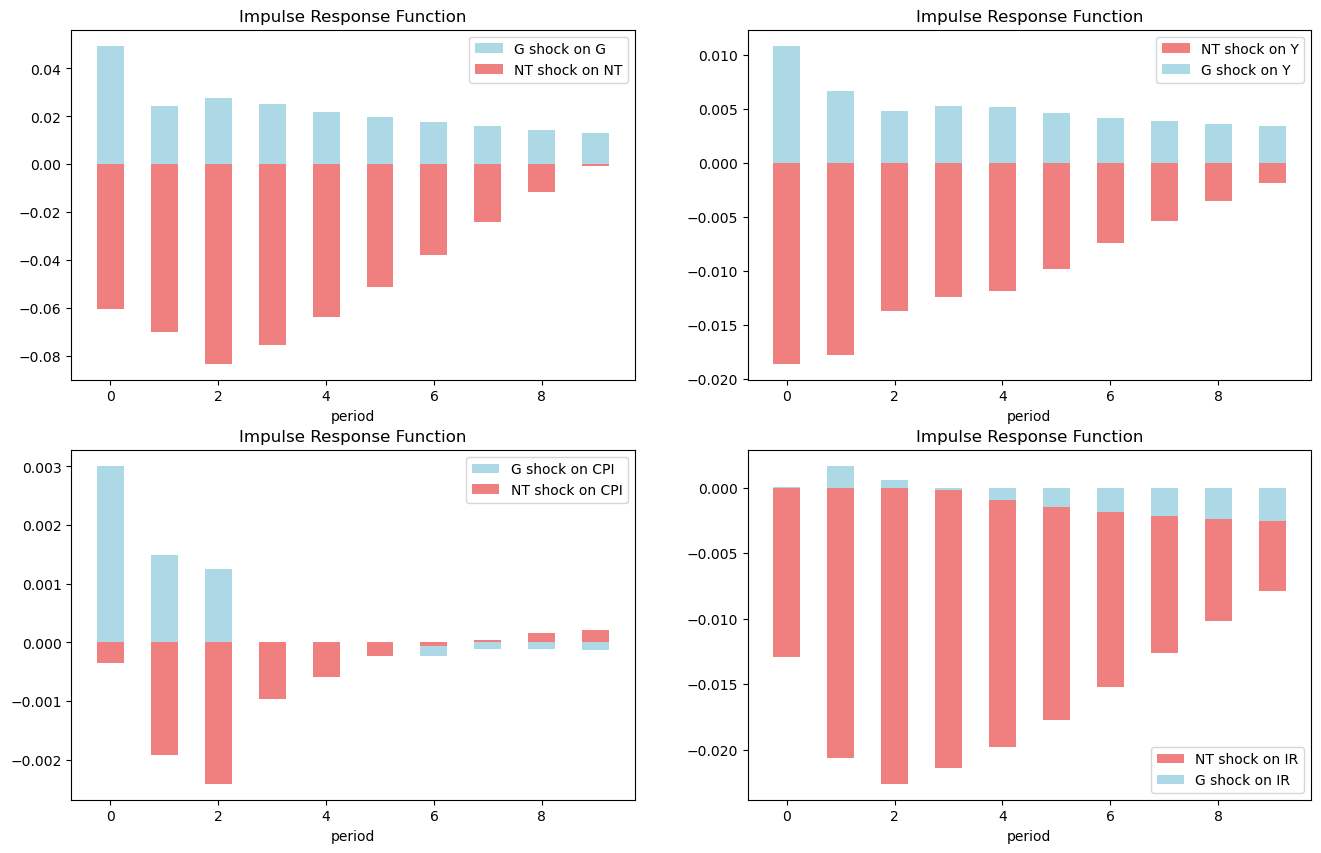

In [14]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.bar(irf.index, irf["Ε_G>G"], label='G shock on G', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(221)
plt.bar(irf.index, irf["Ε_NT>NT"], label='NT shock on NT', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(222)
plt.bar(irf.index, irf["Ε_NT>Y"], label='NT shock on Y', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(222)
plt.bar(irf.index, irf["Ε_G>Y"], label='G shock on Y', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(223)
plt.bar(irf.index, irf["Ε_G>CPI"], label='G shock on CPI', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(223)
plt.bar(irf.index, irf["Ε_NT>CPI"], label='NT shock on CPI', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(224)
plt.bar(irf.index, irf["Ε_NT>IR"], label='NT shock on IR', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(224)
plt.bar(irf.index, irf["Ε_G>IR"], label='G shock on IR', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.show()

### Finally, we produce a table with each of the Multipliers computed:

In [15]:
table = {"Fiscal Shock": ["Government Spending", "Net Taxes"], 
         "GDP Multiplier for the First quarter": [QGM, QNTM], 
         "GDP Multiplier for the First year": [YGM, YNTM] }

Multipliers = pd.DataFrame(table)

In [16]:
Multipliers

,Fiscal Shock,GDP Multiplier for the First quarter,GDP Multiplier for the First year
0,Government Spending,1.087198,1.078007
1,Net Taxes,-1.862053,-1.305000


### As we can see, the multipliers calculated here are quite different than the ones from the paper, for example in our replication both the first quarter and first year multiplier of government spending are above one, suggesting that the results are very sensitive to the identification procedure used. Of course, the Cholesky decomposition used in this exercise is very restrictive, as it imposes no contemporaneous effect on Government Spending and Net taxes from any of our macroeconomic variables (GDP, Inflation and Interest Rates). However, we can take away that the elasticities used in the paper to impose identifying restrictions must be scrutinized very carefully, as they have a huge effect on the conclusions regarding the effectiveness of fiscal policy.